In [2382]:
import pandas as pd
import sklearn
import numpy as np
import re
import time
import warnings
import seaborn as sb
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt   
import seaborn as sns

In [2383]:
train = pd.read_csv("train.csv")
train.head()

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,8.022969
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,7.858458
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,6.341969
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,6.590176
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,6.144782


In [2384]:
train.shape

(32165, 8)

In [2385]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32165 entries, 0 to 32164
Data columns (total 8 columns):
patient_id                    32165 non-null int64
name_of_drug                  32165 non-null object
use_case_for_drug             32165 non-null object
review_by_patient             32165 non-null object
effectiveness_rating          32165 non-null int64
drug_approved_by_UIC          32165 non-null object
number_of_times_prescribed    32165 non-null int64
base_score                    32165 non-null float64
dtypes: float64(1), int64(3), object(4)
memory usage: 2.0+ MB


In [2386]:
train.columns

Index(['patient_id', 'name_of_drug', 'use_case_for_drug', 'review_by_patient',
       'effectiveness_rating', 'drug_approved_by_UIC',
       'number_of_times_prescribed', 'base_score'],
      dtype='object')

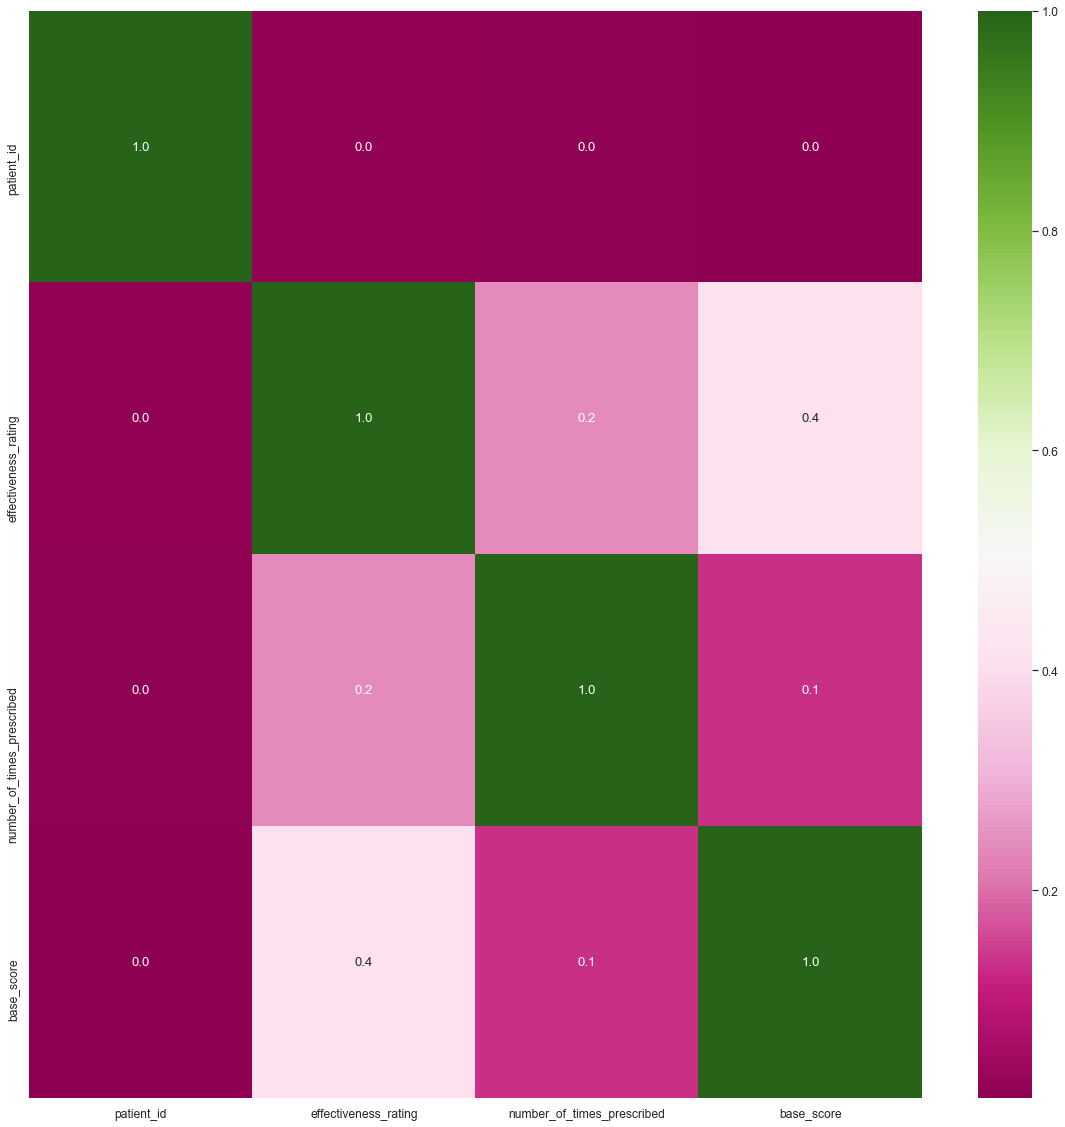

In [2387]:
sb.set(font_scale=1.1)  # big
correlation_train=train.corr()
plt.figure(figsize=(20,20))
sb.heatmap(correlation_train,annot=True,fmt='.1f',cmap='PiYG')

# Feature selection

In [2388]:
corr_dict=correlation_train['base_score'].sort_values(ascending=False).to_dict()
important_columns=[]
for key,value in corr_dict.items():
    if ((value>0.1) & (value<0.8)) | (value<=-0.1):
        important_columns.append(key)
important_columns

['effectiveness_rating', 'number_of_times_prescribed']

In [2389]:
corr_dict

{'base_score': 1.0,
 'effectiveness_rating': 0.4123012926371067,
 'number_of_times_prescribed': 0.1342946849587637,
 'patient_id': 0.010924088100018325}

In [2390]:
data= train[['effectiveness_rating', 'number_of_times_prescribed']]

In [2391]:
#from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
# scaler = MinMaxScaler()
scaler = StandardScaler()
%time scaler.fit(data)
x = scaler.transform(data)
X_train = pd.DataFrame(x,columns =["effectiveness_rating","number_of_times_prescribed"])

Wall time: 1.99 ms


In [2392]:
y_train = train["base_score"]

# XGB Regressor

In [2396]:
from xgboost import XGBRegressor
clf = XGBRegressor(max_depth=11,n_estimators=500,learning_rate=0.1220002222,base_score=0.7)
%time clf.fit( X_train , y_train )

Wall time: 5.87 s


XGBRegressor(base_score=0.7, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1220002222, max_delta_step=0, max_depth=11,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

# Test Data

In [2397]:
test = pd.read_csv("test.csv")
test.head()

,patient_id,name_of_drug,review_by_patient,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug,effectiveness_rating
0,163740,Mirtazapine,"""I&#039;ve tried a few antidepressants over th...",28-Feb-12,22,Depression,10
1,39293,Contrave,"""Contrave combines drugs that were used for al...",5-Mar-17,35,Weight Loss,9
2,208087,Zyclara,"""4 days in on first 2 weeks. Using on arms an...",3-Jul-14,13,Keratosis,4
3,23295,Methadone,"""Ive been on Methadone for over ten years and ...",18-Oct-16,21,Opiate Withdrawal,7
4,97013,Ambien,"""Ditto on rebound sleepless when discontinued....",13-Jan-15,44,Insomnia,2


In [2398]:
test.shape

(10760, 7)

In [2399]:
test= test[['effectiveness_rating', 'number_of_times_prescribed']]

In [2400]:
x = scaler.transform(test)
test = pd.DataFrame(x,columns =["effectiveness_rating","number_of_times_prescribed"])
test.shape

(10760, 2)

In [2401]:
y_pred = clf.predict(test)

In [2402]:
y_pred.shape

(10760,)

In [2403]:
test = pd.read_csv("test.csv")
test.head()

,patient_id,name_of_drug,review_by_patient,drug_approved_by_UIC,number_of_times_prescribed,use_case_for_drug,effectiveness_rating
0,163740,Mirtazapine,"""I&#039;ve tried a few antidepressants over th...",28-Feb-12,22,Depression,10
1,39293,Contrave,"""Contrave combines drugs that were used for al...",5-Mar-17,35,Weight Loss,9
2,208087,Zyclara,"""4 days in on first 2 weeks. Using on arms an...",3-Jul-14,13,Keratosis,4
3,23295,Methadone,"""Ive been on Methadone for over ten years and ...",18-Oct-16,21,Opiate Withdrawal,7
4,97013,Ambien,"""Ditto on rebound sleepless when discontinued....",13-Jan-15,44,Insomnia,2


In [2404]:
sub1 = pd.DataFrame({'patient_id': test.patient_id, 'base_score':y_pred})
sub1.to_csv('solution.csv', index=False)

In [2405]:
sub1.head()

,patient_id,base_score
0,163740,8.756999
1,39293,8.745531
2,208087,5.952264
3,23295,5.993707
4,97013,5.367795
